Script that takes nr data files, take signal in our direction, taper the start, propagate to the detectors, add noise, inject into detectors, plot.

We currently have
- setup + overhead + parameter initialization stuff
- lalsuite to extract inc=0 data, extract t1, f1 for tapering
- lalsuite to extract a more general angle
- apply three tapering fcns to beginning and end
- add padding on both sides
- bilby propagating to detectors
- ifo bilby detector injection and adding noise
- some data set creations
- create csv and metadata ringdown needs

What I want to add
- Some cleaning up, removing fcns, plots, comments we dont need
- Add a box at the top to set the adjustable parameters (like padding, tapering fcns, dec angle etc)


First some imports

In [1]:
import bilby 
from bilby.core.prior import Uniform
from bilby.gw.utils import asd_from_freq_series

import numpy as np
import matplotlib
matplotlib.use("Qt5Agg") 
import matplotlib.pyplot as plt
%matplotlib widget
import h5py
import lalsimulation as lalsim
import lal
import os

from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar


/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


Define some helpers:

In [2]:
#some inverse fourier transform helper 
def infft(frequency_domain_strain, sampling_frequency, length=None):
    """ Inverse FFT for use in conjunction with nfft.

    Parameters
    ----------
    frequency_domain_strain: array_like
        Single-sided, normalised FFT of the time-domain strain data (in units
        of strain / Hz).
    sampling_frequency: int, float
        Sampling frequency of the data.
    length: float
        length of the transformed axis of the output.
    """

    time_domain_strain_norm = np.fft.irfft(frequency_domain_strain, n=length)
    time_domain_strain = time_domain_strain_norm * sampling_frequency
    return time_domain_strain

Some bibly overhead

In [3]:
# Specify the output directory and the name of the simulation.
# bilby setup stuff
outdir = "outdir"
label = "phenomXP"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

Set parameters from NR injection waveform

In [4]:
# Set the binary parameters of the NR inejection waveform
# this is the angle and distance to the source
inclination = 0 #!!!this needs to be 0 for tapering calc
luminosity_distance = 25.
distance = luminosity_distance * lal.PC_SI * 1.0e6
phiRef = 0.0

# our relevant file path - create separate folder system
#filepath = 'chombo/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
filepath = 'chombo/GRChombo_BBSsol02_A17A17q100d17p000_Res40.h5' #DO THIS ONE NEXT
# pick parameters to mimic 25 event (inc,sky pos (?), total mass) (corresponding sky location (α = 2.333, δ = 0.190))
#  time tpeak = 1420878141.235932 s at geocenter
#filepath = 'grav_wave_boson_star_testing_gr/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
f = h5py.File(filepath, 'r')

In [5]:
#some settings
taper_end = True
dense_star = True

Set up dictionary to store parameters. Populate it

In [6]:
# setting up dict to feed parameters into waveforms
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

# Metadata parameters masses
mtotal = 71.849 # in solar masses. set total mass scale - sim only has relative
# extract masses and convert to different units
m1 = f.attrs['mass1'] #code units
m2 = f.attrs['mass2']

mass_1 = m1 * mtotal / (m1 + m2) #solar masses
mass_2 = m2 * mtotal / (m1 + m2)

# Choose extrinsic parameters

m1SI = mass_1 * lal.MSUN_SI #in kg
m2SI = mass_2 * lal.MSUN_SI

spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(0., mtotal, filepath)
s1x, s1y, s1z = spins[0], spins[1], spins[2]
s2x, s2y, s2z = spins[3], spins[4], spins[5]

# Set sampling frequency of the data segment that we're going to inject the signal into
# just be aware of aliasing issues if too low
sampling_frequency = 4096.0  # Hz
deltaT = 1.0/sampling_frequency #cadence

# we need to set the lowest trustable frequency - set as lowest simulated frequency, scaled by the chosen mass
#CHANGE THIS AFTER DOING THE TAPERING
f_lower = f.attrs['f_lower_at_1MSUN']/mtotal  # this choice generates the whole NR waveforms from the beginning
fRef = 0   #beginning of the waveform
fStart = f_lower


In [7]:
f.close()

Use `lalsim` to generate the waveform polarisations for the injection.

In [8]:
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

approx = lalsim.NR_hdf5

inject_l_modes=[2]
ModeArray = lalsim.SimInspiralCreateModeArray()
for mode in inject_l_modes:
    lalsim.SimInspiralModeArrayActivateAllModesAtL(ModeArray, mode)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ModeArray)

# these are the steps we need to redo later, with a new inclination angle
h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

In [9]:
phase = np.arctan2(h_c.data.data, h_p.data.data)
unwrapped_phase = np.unwrap(phase)
unwrapped_phase_interp = UnivariateSpline(times, unwrapped_phase, k=3, s=0)
omega_interp = unwrapped_phase_interp.derivative() 
frequency = omega_interp(times) / (2.0 * np.pi)

safety = 2 #can increase this
sol = root_scalar(lambda t1: (1+safety)*(1./t1)-omega_interp(t1)/(2.0*np.pi),
                    x0 = 0.1, 
                    bracket=[0.01, 0.3])
t0, t1 = 0., sol.root
f0, f1 = omega_interp(t0)/(2.0*np.pi), omega_interp(t1)/(2.0*np.pi)
print(f"{t0=:.2e}, {f0=:.2e}, {t1=:.2e}, {f1=:.2e}")

minimum_frequency = f1


t0=0.00e+00, f0=2.07e+01, t1=1.29e-01, f1=2.33e+01


Now we extract the signal again with the other inc

In [10]:
inclination = 0.78 

h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

In [11]:
# old window fcn

# def window(times, t0, t1):
#     taper = np.ones_like(times)
#     mask = (times >= t0) & (times <= t1)
#     taper[mask] = 0.5 * (1 - np.cos(np.pi * (times[mask] - t0) / (t1 - t0)))
#     return taper

In [12]:
from scipy.signal import windows

def window(times, t0, t1, kind='cosine', direction='on'):

    taper = np.ones_like(times)
    mask = (times >= t0) & (times <= t1)
    x = (times[mask] - t0) / (t1 - t0) # Normalized [0, 1] range

    if kind == 'cosine':
        taper[mask] = 0.5 * (1 - np.cos(np.pi * x))

    elif kind == "plancktaper":
        taper[mask] = np.array([
            1 / (np.exp((1 / xi) - (1 / (1 - xi))) + 1)
            if 0 < xi < 1 else (1.0 if xi >= 1 else 0.0)
            for xi in x
        ])
    
    else:
        # Generate a standard SciPy window and take only the first half
        n = np.count_nonzero(mask)
        try:
            wfunc = getattr(windows, kind)
            w = wfunc(n * 2)[:n] 
            w /= w.max()
            taper[mask] = w
        except AttributeError:
            raise ValueError(f"Unknown window type '{kind}'")

    if direction == 'off':
        # Flip the taper and set regions outside [t0, t1] appropriately
        taper[mask] = 1 - taper[mask]
        taper[times < t0] = 1.0
        taper[times > t1] = 0.0
    else:  # direction == 'on'
        taper[times < t0] = 0.0
        taper[times > t1] = 1.0

    return taper

In [13]:
wf = 'cosine'

taper = window(times, t0, t1, kind=wf, direction='on')
tapered_hp = h_p.data.data * taper
tapered_hc = h_c.data.data * taper

We plot the results

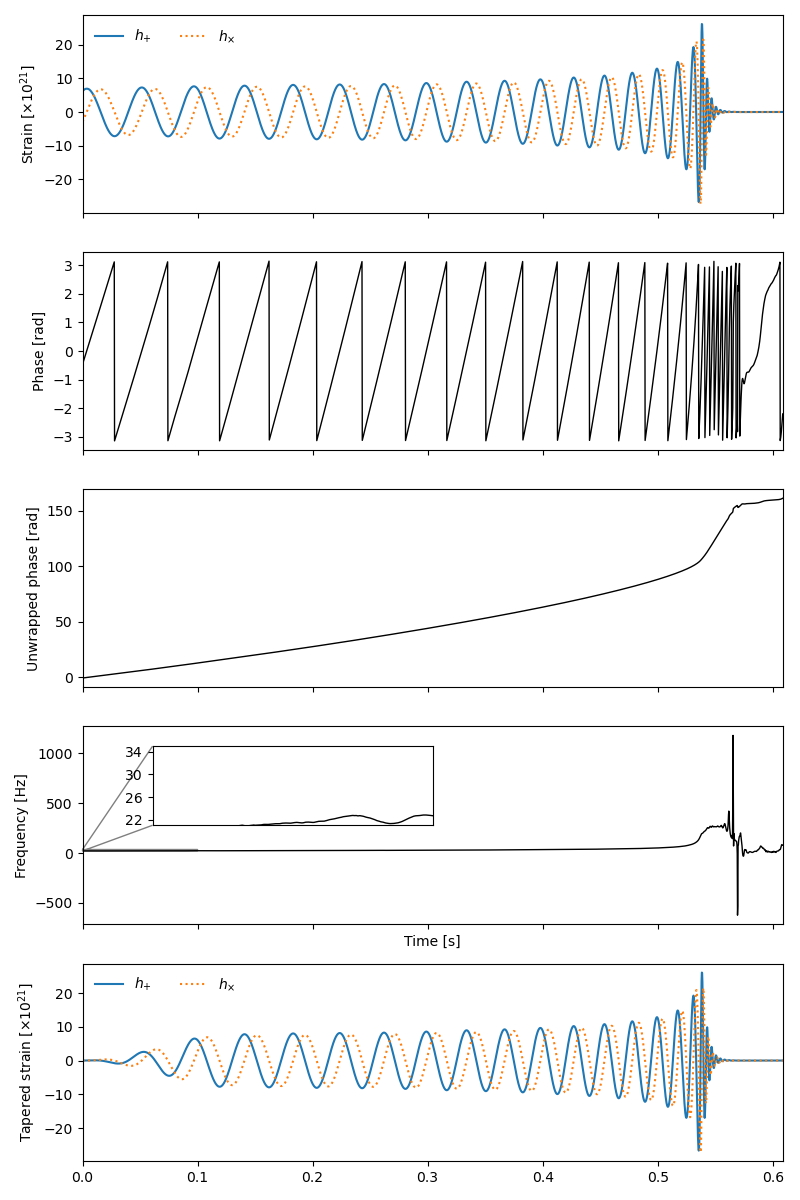

In [14]:
fig, axes = plt.subplots(nrows=5, sharex=True, figsize=(8, 12))

# plot initial signal
axes[0].plot(times, 1.0e21*h_p.data.data, ls='-', label=r'$h_{+}$')
axes[0].plot(times, 1.0e21*h_c.data.data, ls=':', label=r'$h_{\times}$')
axes[0].set_ylabel(r'Strain [$\times 10^{21}$]')
axes[0].set_xlim(times[0], times[-1])
axes[0].legend(loc='upper left', frameon=False, ncols=2)

# plot phase
axes[1].plot(times, phase, 'k-', lw=1)
axes[1].set_ylabel('Phase [rad]')

# unwrapped phase
axes[2].plot(times, unwrapped_phase, 'k-', lw=1)
axes[2].set_ylabel('Unwrapped phase [rad]')

# frequency
axes[3].plot(times, frequency, 'k-', lw=1)
axes[3].set_xlabel('Time [s]')
axes[3].set_ylabel('Frequency [Hz]')

# zoomed frequency window
x1, x2, y1, y2 = 0.0, 0.1, 21.0, 35.0  # subregion of the original image
axins = axes[3].inset_axes(
    [0.1, 0.5, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[], yticks=np.arange(22., 36.1, 4.))
axins.plot(times, frequency, 'k-', lw=1)
axes[3].indicate_inset_zoom(axins, edgecolor="black")

# after tapering
axes[4].plot(times, 1.0e21*tapered_hp, ls='-', label=r'$h_{+}$')
axes[4].plot(times, 1.0e21*tapered_hc, ls=':', label=r'$h_{\times}$')
axes[4].set_ylabel(r'Tapered strain [$\times 10^{21}$]')
axes[4].set_xlim(times[0], times[-1])
axes[4].legend(loc='upper left', frameon=False, ncols=2)

plt.tight_layout()
plt.show()

We taper the end of the signal. I want to start the taper after the last max, which is at about 0.4518

In [35]:
def find_peaks(hp):
    """
    Find peaks by sign change in derivative: dhp/dt goes + -> -.
    Returns array of indices (index corresponds to sample where sign change occurs).
    """
    d_hp = np.diff(hp)
    # look for positive -> negative sign change
    sign_change = (d_hp[:-1] > 0) & (d_hp[1:] < 0)
    peaks = np.where(sign_change)[0] + 1
    return peaks

def nth_last_peak(hp, times, n=1):
    peaks = find_peaks(hp)
    nth_idx = peaks[-n]
    nth_time = times[nth_idx]
    nth_value = hp[nth_idx]
    return nth_idx, nth_time, nth_value

n = 8
idx_taper = find_peaks(h_p.data.data)[-n]

In [36]:
# taper the end of the signal
if taper_end == True:
    t_start = times[idx_taper] if idx_taper < len(times) else times[-1]
    t_end = times[-1]

    if t_start >= t_end:
        raise ValueError(f"Invalid taper interval: t_start ({t_start}) >= t_end ({t_end})")

    # build an end taper that goes from 0 -> 1 over [t_start, t_end] (using the same kind as the start taper)
    end_taper = window(times, t_start, t_end, kind=wf, direction='off')
    # combine with the existing start taper
    taper = taper * end_taper

    # update the stored tapers and tapered signals
    tapered_hp = tapered_hp * end_taper
    tapered_hc = tapered_hc * end_taper

    print(f"End taper applied starting at times[{idx_taper}] = {t_start:.6f} s to {t_end:.6f} s")

End taper applied starting at times[2317] = 0.565674 s to 0.608643 s


In [37]:
# Plot original + newly tapered signals (plus, cross, amplitude)
# fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# # original waveforms
# orig_hp = h_p.data.data
# orig_hc = h_c.data.data
# ax[0].plot(times, orig_hp, color="k", lw=1.2, label="original h_plus")
# ax[1].plot(times, orig_hc, color="k", lw=1.2, label="original h_cross")

# # tapered waveforms
# for wf in window_funcs:
#     ax[0].plot(times, tapered_hp_dict[wf], label=f"{wf} (plus)", alpha=0.9)
#     ax[1].plot(times, tapered_hc_dict[wf], ls="--", label=f"{wf} (cross)", alpha=0.9)

# # labels, limits and legend
# ax[0].set_ylabel("Strain")
# ax[1].set_ylabel("Strain")
# ax[0].set_xlim(times[0], times[-1])
# for a in ax:
#     a.legend(loc="upper left", fontsize=9, frameon=False)

# plt.tight_layout()
# plt.show()

We plot the beginning and end of the plus and cross signal to see the effect of the tapering

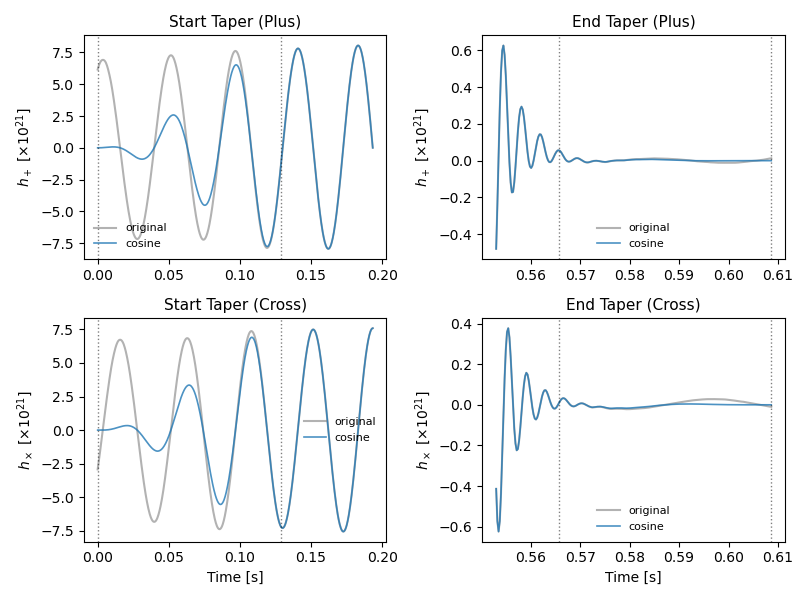

In [38]:
if taper_end == True:

    # Create a figure with 2 rows (h+, hx) and 2 columns (start, end)
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    # Define narrow windows around the tapers
    # Start taper window: show a bit before and after the taper
    start_margin = (t1 - t0) * 0.5
    start_mask = (times >= t0 - start_margin) & (times <= t1 + start_margin)

    # End taper window: show a bit before and after the taper
    end_margin = (t_end - t_start) * 0.3
    end_mask = (times >= t_start - end_margin) & (times <= t_end + end_margin)

    # Extract time arrays for each region
    times_start = times[start_mask]
    times_end = times[end_mask]

    # Original waveforms
    orig_hp = h_p.data.data
    orig_hc = h_c.data.data

    # Plot h+ (top row)
    # Start region
    ax[0, 0].plot(times_start, 1e21 * orig_hp[start_mask], color="gray", 
                lw=1.5, label="original", alpha=0.6)
    ax[0, 0].plot(times_start, 1e21 * tapered_hp[start_mask], 
                label=f"{wf}", alpha=0.8, lw=1.2)
    ax[0, 0].axvline(t0, color='k', ls=':', alpha=0.5, lw=1)
    ax[0, 0].axvline(t1, color='k', ls=':', alpha=0.5, lw=1)
    ax[0, 0].set_ylabel(f"$h_+$ [$\\times 10^{{21}}$]")
    ax[0, 0].set_title("Start Taper (Plus)", fontsize=11)
    ax[0, 0].legend(loc="best", fontsize=8, frameon=False)

    # End region
    ax[0, 1].plot(times_end, 1e21 * orig_hp[end_mask], color="gray", 
                lw=1.5, label="original", alpha=0.6)
    ax[0, 1].plot(times_end, 1e21 * tapered_hp[end_mask], 
                label=f"{wf}", alpha=0.8, lw=1.2)
    ax[0, 1].axvline(t_start, color='k', ls=':', alpha=0.5, lw=1)
    ax[0, 1].axvline(t_end, color='k', ls=':', alpha=0.5, lw=1)
    ax[0, 1].set_ylabel(f"$h_+$ [$\\times 10^{{21}}$]")
    ax[0, 1].set_title("End Taper (Plus)", fontsize=11)
    ax[0, 1].legend(loc="best", fontsize=8, frameon=False)

    # Plot hx (bottom row)
    # Start region
    ax[1, 0].plot(times_start, 1e21 * orig_hc[start_mask], color="gray", 
                lw=1.5, label="original", alpha=0.6)
    ax[1, 0].plot(times_start, 1e21 * tapered_hc[start_mask], 
                label=f"{wf}", alpha=0.8, lw=1.2)
    ax[1, 0].axvline(t0, color='k', ls=':', alpha=0.5, lw=1)
    ax[1, 0].axvline(t1, color='k', ls=':', alpha=0.5, lw=1)
    ax[1, 0].set_xlabel("Time [s]")
    ax[1, 0].set_ylabel(f"$h_\\times$ [$\\times 10^{{21}}$]")
    ax[1, 0].set_title("Start Taper (Cross)", fontsize=11)
    ax[1, 0].legend(loc="best", fontsize=8, frameon=False)

    # End region
    ax[1, 1].plot(times_end, 1e21 * orig_hc[end_mask], color="gray", 
                lw=1.5, label="original", alpha=0.6)
    ax[1, 1].plot(times_end, 1e21 * tapered_hc[end_mask], 
                label=f"{wf}", alpha=0.8, lw=1.2)
    ax[1, 1].axvline(t_start, color='k', ls=':', alpha=0.5, lw=1)
    ax[1, 1].axvline(t_end, color='k', ls=':', alpha=0.5, lw=1)
    ax[1, 1].set_xlabel("Time [s]")
    ax[1, 1].set_ylabel(f"$h_\\times$ [$\\times 10^{{21}}$]")
    ax[1, 1].set_title("End Taper (Cross)", fontsize=11)
    ax[1, 1].legend(loc="best", fontsize=8, frameon=False)

    plt.tight_layout()
    plt.show() 

We pad the signal:

In [39]:
pad_factor = 4  # Pad with signal_length on each side
signal_length = len(times)
pad_length = int(signal_length * pad_factor)

# Get the time step (assuming uniform sampling)
dt = times[1] - times[0]

# Create new time array with padding
times_before = times[0] - np.arange(pad_length, 0, -1) * dt
times_after = times[-1] + np.arange(1, pad_length + 1) * dt
# Combine all times
times_padded = np.concatenate([times_before, times, times_after])
# shift to start at t=0
times_padded = times_padded-times_padded[0]

# Pad with zeros on each side
padded_hp = np.pad(tapered_hp, pad_length, mode='constant', constant_values=0)
padded_hc = np.pad(tapered_hc, pad_length, mode='constant', constant_values=0)
padded_taper = np.pad(taper, pad_length, mode='constant', constant_values=0)

print(f"Original signal length: {signal_length} points ({times[0]:.4f} s to {times[-1]:.4f} s)")
print(f"Padded signal length: {len(times_padded)} points ({times_padded[0]:.4f} s to {times_padded[-1]:.4f} s)")
print(f"Padding: {pad_length} points ({pad_length * dt:.4f} s) on each side")
print(f"Signal now occupies {100 * signal_length / len(times_padded):.1f}% of total length")

Original signal length: 2494 points (0.0000 s to 0.6086 s)
Padded signal length: 22446 points (0.0000 s to 5.4797 s)
Padding: 9976 points (2.4355 s) on each side
Signal now occupies 11.1% of total length


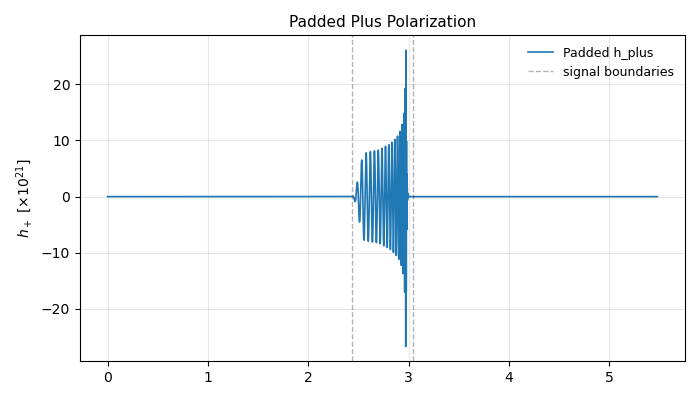

In [40]:
# Plot the padded signals
fig = plt.figure(figsize=(7, 4))

plt.plot(times_padded, 1e21 * padded_hp, 
            label="Padded h_plus", lw=1.2, color='C0')

# Mark where original signal starts and ends
plt.axvline(times_padded[pad_length], color='k', ls='--', alpha=0.3, lw=1, label='signal boundaries')
plt.axvline(times_padded[pad_length + signal_length - 1], color='k', ls='--', alpha=0.3, lw=1)
plt.ylabel(f"$h_+$ [$\\times 10^{{21}}$]")
plt.title("Padded Plus Polarization", fontsize=11)
plt.legend(loc="best", fontsize=9, frameon=False)
plt.grid(alpha=0.3)

# Plot hx (bottom)
# for i, wf in enumerate(window_funcs):
#     ax[1].plot(times_padded, 1e21 * padded_hc_dict[wf], 
#                label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])

# ax[1].axvline(times_padded[pad_length], color='k', ls='--', alpha=0.3, lw=1, label='signal boundaries')
# ax[1].axvline(times_padded[pad_length + signal_length - 1], color='k', ls='--', alpha=0.3, lw=1)
# ax[1].set_xlabel("Time [s]")
# ax[1].set_ylabel(f"$h_\\times$ [$\\times 10^{{21}}$]")
# ax[1].set_title("Padded Cross Polarization", fontsize=11)
# ax[1].legend(loc="best", fontsize=9, frameon=False)
# ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

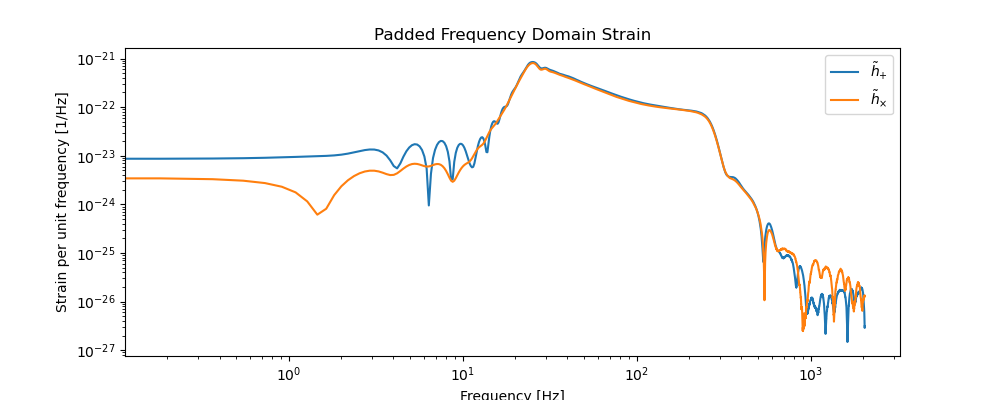

In [41]:
# plot frequency domain strain
padded_fr_plus = np.fft.rfft(padded_hp) / sampling_frequency
padded_fr_cross = np.fft.rfft(padded_hc) / sampling_frequency
freqs = np.fft.rfftfreq(len(padded_hp), d=1.0/sampling_frequency)

plt.figure(figsize=(10, 4))
plt.loglog(freqs, np.abs(padded_fr_plus), label='$\~h_{+}$')
plt.loglog(freqs, np.abs(padded_fr_cross), label='$\~h_{\\times}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain per unit frequency [1/Hz]')
plt.title('Padded Frequency Domain Strain')
plt.legend()
plt.show()

In [42]:
bandpass_filter = True
window_filter = False

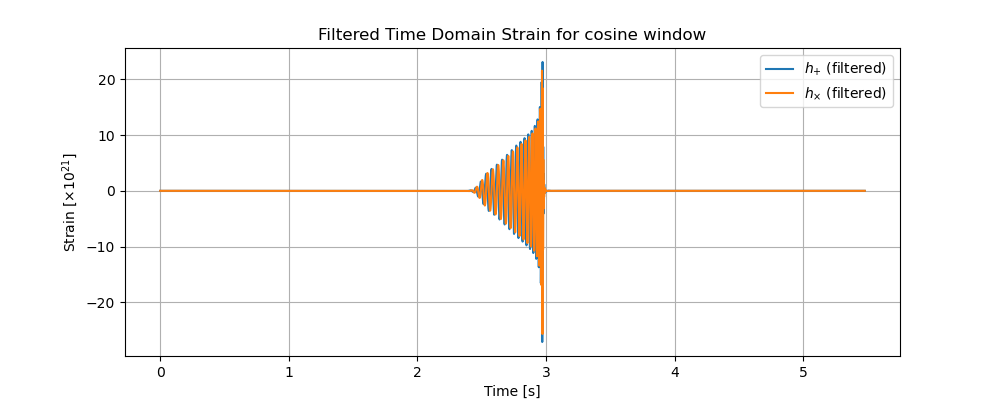

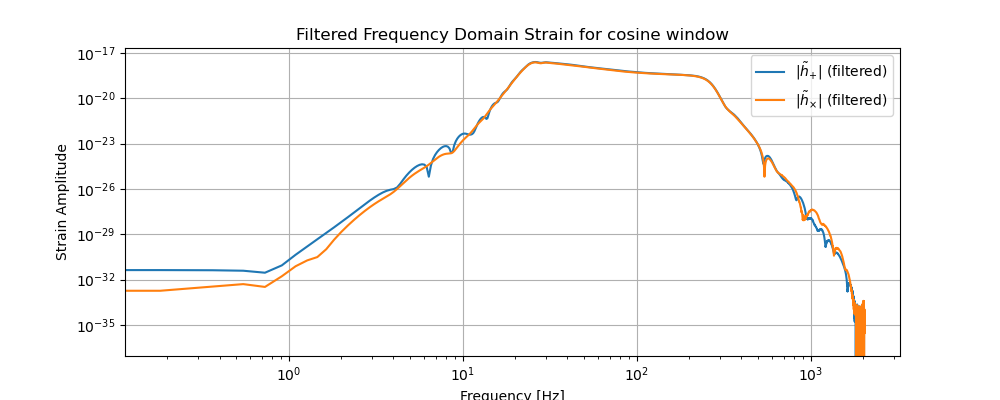

In [43]:
# apply band pass filter before injecting into ifos
if bandpass_filter:
    from scipy.signal import butter, sosfiltfilt
    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
        y = sosfiltfilt(sos, data)
        return y
    lowcut = minimum_frequency  # Hz
    highcut = 270  # Hz - by eye
    fs = 4096.0  # Sampling frequency in Hz
    filtered_hp = bandpass_filter(padded_hp, lowcut, highcut, fs)
    filtered_hc = bandpass_filter(padded_hc, lowcut, highcut, fs)
    # plot filtered time domain strain
    plt.figure(figsize=(10, 4))
    plt.plot(times_padded, 1.0e21*filtered_hp, label='$h_{+}$ (filtered)')
    plt.plot(times_padded, 1.0e21*filtered_hc, label='$h_{\\times}$ (filtered)')
    plt.xlabel('Time [s]')
    plt.ylabel('Strain [$\\times 10^{21}$]')
    plt.title(f'Filtered Time Domain Strain for {wf} window')
    plt.legend()
    plt.grid()
    plt.show()

    #plot filtered frequency domain strain
    from scipy.fft import rfft, rfftfreq
    N = len(times_padded)
    T = 1.0 / sampling_frequency
    yf_hp = rfft(filtered_hp)
    yf_hc = rfft(filtered_hc)
    xf = rfftfreq(N, T)
    plt.figure(figsize=(10, 4))
    plt.loglog(xf, np.abs(yf_hp), label='$|\\tilde{h}_{+}|$ (filtered)')
    plt.loglog(xf, np.abs(yf_hc), label='$|\\tilde{h}_{\\times}|$ (filtered)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Strain Amplitude')
    plt.title(f'Filtered Frequency Domain Strain for {wf} window')
    plt.legend()
    plt.grid()
    plt.show()

In [44]:
if window_filter:
    #instead of band pass, try to apply a simple window function in frequency domain
    def frequency_window(frequencies, f_low, f_high):
        window = np.zeros_like(frequencies)
        mask = (frequencies >= f_low) & (frequencies <= f_high)
        window[mask] = 1.0
        return window

    fr_domain = {}
    fr_domain['plus'] = np.fft.rfft(padded_hp) / sampling_frequency
    fr_domain['cross'] = np.fft.rfft(padded_hc) / sampling_frequency
    fr_array = np.fft.rfftfreq(len(times_padded), d=1.0/sampling_frequency)

    lowcut = minimum_frequency  # Hz
    highcut = 270  # Hz - by eye

    f_window = frequency_window(fr_array, lowcut, highcut)
    windowed_fr_plus = fr_domain['plus'] * f_window
    windowed_fr_cross = fr_domain['cross'] * f_window

    # plot windowed frequency domain strain
    plt.figure(figsize=(10, 4))
    plt.loglog(fr_array, np.abs(windowed_fr_plus), label='$|\\tilde{h}_{+}|$ (windowed)')
    plt.loglog(fr_array, np.abs(windowed_fr_cross), label='$|\\tilde{h}_{\\times}|$ (windowed)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Strain Amplitude')
    plt.title(f'Windowed Frequency Domain Strain for {wf} window')
    plt.legend()
    plt.grid()
    plt.show()

    # convert back to time domain
    filtered_hp = infft(windowed_fr_plus, sampling_frequency, length=len(times_padded))
    filtered_hc = infft(windowed_fr_cross, sampling_frequency, length=len(times_padded))
    # plot windowed time domain strain
    plt.figure(figsize=(10, 4))
    plt.plot(times_padded, 1.0e21*filtered_hp, label='$h_{+}$ (windowed)')
    plt.plot(times_padded, 1.0e21*filtered_hc, label='$h_{\\times}$ (windowed)')
    plt.xlabel('Time [s]')
    plt.ylabel('Strain [$\\times 10^{21}$]')
    plt.title(f'Windowed Time Domain Strain for {wf} window')
    plt.legend()
    plt.grid()
    plt.show()

In [45]:
preprocessed_hp = filtered_hp if (bandpass_filter or window_filter) else padded_hp 
preprocessed_hc = filtered_hc if (bandpass_filter or window_filter) else padded_hc

We use bilby:

In [46]:
def create_nr_injection(times_array, hp_array, hc_array):
    """
    Factory function that creates a custom NR injection function
    with specific time series data.
    """
    def nr_injection(time):
            
        hp = np.interp(time, times_array, hp_array)
        hc = np.interp(time, times_array, hc_array)
        return {"plus": hp, "cross": hc}
    
    return nr_injection

09:52 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=5.47998046875, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})


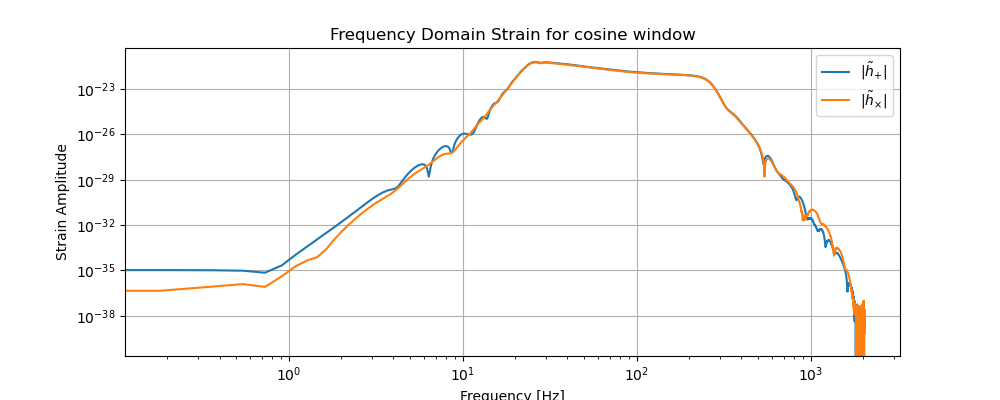

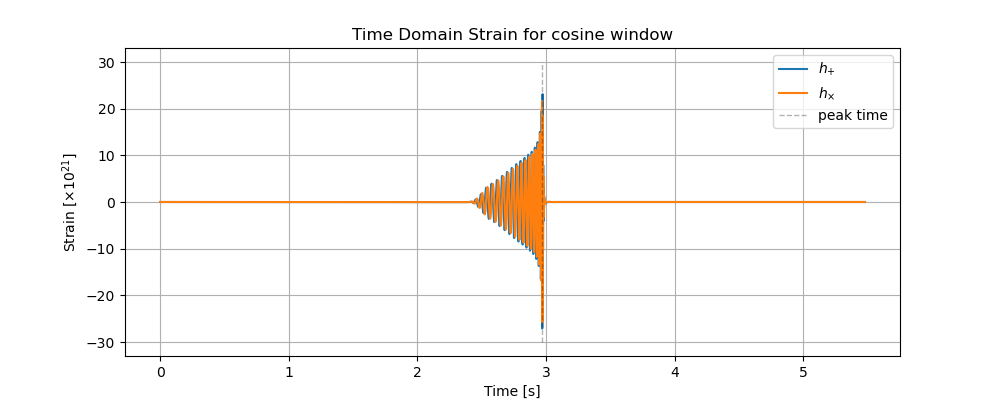

In [47]:
# propagate and inject each tapered signal
# create dict to store the data
original_hp = np.copy(h_p.data.data)
original_hc = np.copy(h_c.data.data)

amplitude = np.sqrt(preprocessed_hp**2 + preprocessed_hc**2)
peak_id = np.argmax(amplitude)
peak = times_padded[peak_id]

hplus = preprocessed_hp[peak_id]
hcross = preprocessed_hc[peak_id]
phase_merger = np.arctan2(-hcross,hplus) + np.pi


#duration = times_padded[-1]
start_time = times_padded[0]
signal_start_time = times_padded[pad_length]
duration = len(times_padded) / sampling_frequency
geocent_time = 1420878141.235932 #(for use later, ignore for now)

np.random.seed(88170235)
injection_parameters = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0.0,
    phi_jl=0.0,
    luminosity_distance=luminosity_distance,
    theta_jn=inclination,
    psi=1.329, #used to be np.pi/2
    phase=phase_merger,
    geocent_time=0,
    ra=2.333,
    dec=0.190
)

# bibly assumes a signal centered at 0 and then applies a geocentric time shift, so we must shift our signal accordingly
# roll the arrays so the peak is at index 0
#hp_rolled = np.roll(preprocessed_hp, -peak_id)
#hc_rolled = np.roll(preprocessed_hc, -peak_id)
hp_rolled = preprocessed_hp
hc_rolled = preprocessed_hc

nr_injection_wf = create_nr_injection(times_padded, hp_rolled, hc_rolled)

# propagate to interferometers
waveform = bilby.gw.waveform_generator.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
        time_domain_source_model=nr_injection_wf, start_time=0);

# get time and frequency domain strains and arrays
time_domain = waveform.time_domain_strain(parameters=injection_parameters);
time_array = waveform.time_array

fr_domain = waveform.frequency_domain_strain(parameters=injection_parameters);
fr_array = waveform.frequency_array

# these still look good, no weird shifts


# plot frequency domain strain
plt.figure(figsize=(10, 4))
plt.loglog(fr_array, np.abs(fr_domain['plus']), label='$|\\tilde{h}_{+}|$')
plt.loglog(fr_array, np.abs(fr_domain['cross']), label='$|\\tilde{h}_{\\times}|$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain Amplitude')
plt.title(f'Frequency Domain Strain for {wf} window')
plt.legend()
plt.grid()
plt.show()
#plot time domain strain
plt.figure(figsize=(10, 4))
plt.plot(time_array, 1.0e21*time_domain['plus'], label='$h_{+}$')
plt.plot(time_array, 1.0e21*time_domain['cross'], label='$h_{\\times}$')
plt.vlines(peak, -30, 30, color='k', ls='--', alpha=0.3, lw=1, label='peak time')
plt.xlabel('Time [s]')
plt.ylabel('Strain [$\\times 10^{21}$]')
plt.title(f'Time Domain Strain for {wf} window')
plt.legend()
plt.grid()
plt.show()
#can try to suppress high freqs here, see if that fixes post bilby signals (band pass filter)

In [48]:
# create ifos and inject signal and noise
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1']);
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=start_time);
ifos.inject_signal(waveform_generator=waveform,
                parameters=injection_parameters, raise_error=False);

09:52 bilby INFO    : Injected signal in H1:
09:52 bilby INFO    :   optimal SNR = 568.09
09:52 bilby INFO    :   matched filter SNR = 566.99-0.13j
09:52 bilby INFO    :   mass_1 = 35.9245
09:52 bilby INFO    :   mass_2 = 35.9245
09:52 bilby INFO    :   a_1 = 0.0
09:52 bilby INFO    :   a_2 = 0.0


09:52 bilby INFO    :   tilt_1 = 0.0
09:52 bilby INFO    :   tilt_2 = 0.0
09:52 bilby INFO    :   phi_12 = 0.0
09:52 bilby INFO    :   phi_jl = 0.0
09:52 bilby INFO    :   luminosity_distance = 25.0
09:52 bilby INFO    :   theta_jn = 0.78
09:52 bilby INFO    :   psi = 1.329
09:52 bilby INFO    :   phase = 5.93157211412735
09:52 bilby INFO    :   geocent_time = 0
09:52 bilby INFO    :   ra = 2.333
09:52 bilby INFO    :   dec = 0.19
09:52 bilby INFO    : Injected signal in L1:
09:52 bilby INFO    :   optimal SNR = 549.24
09:52 bilby INFO    :   matched filter SNR = 549.53-0.91j
09:52 bilby INFO    :   mass_1 = 35.9245
09:52 bilby INFO    :   mass_2 = 35.9245
09:52 bilby INFO    :   a_1 = 0.0
09:52 bilby INFO    :   a_2 = 0.0
09:52 bilby INFO    :   tilt_1 = 0.0
09:52 bilby INFO    :   tilt_2 = 0.0
09:52 bilby INFO    :   phi_12 = 0.0
09:52 bilby INFO    :   phi_jl = 0.0
09:52 bilby INFO    :   luminosity_distance = 25.0
09:52 bilby INFO    :   theta_jn = 0.78
09:52 bilby INFO    :   psi 

In [49]:
#locate the merger (peak amplitude) in the ifo data
ifo = ifos[0]  # pick one interferometer to plot
times_ifo = ifo.time_array
strain = ifo.time_domain_strain
amplitude = np.sqrt(strain**2)
peak_id_ifo = np.argmax(amplitude)
peak_time_ifo = times_ifo[peak_id_ifo]

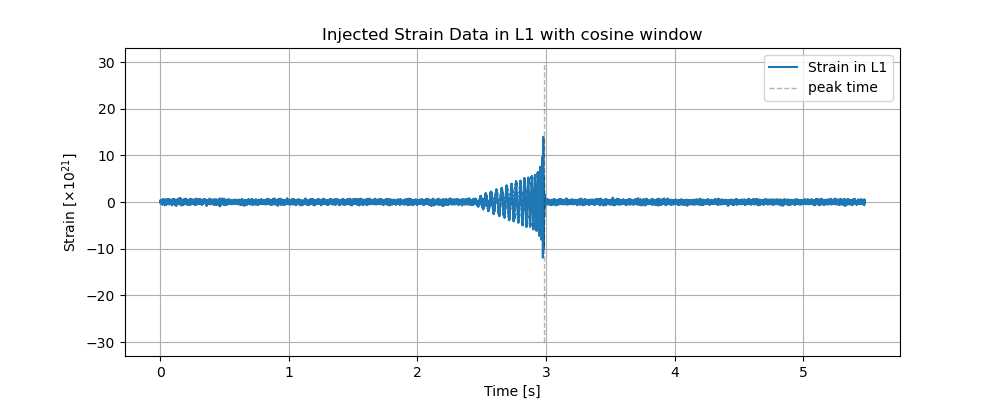

In [50]:
# try some plotting of the ifo data

ifo = ifos[1]  # pick one interferometer to plot
times_ifo = ifo.time_array
strain = ifo.time_domain_strain
plt.figure(figsize=(10, 4))
plt.plot(times_ifo, 1.0e21*strain, label=f'Strain in {ifo.name}')
plt.vlines(peak_time_ifo, -30, 30, color='k', ls='--', alpha=0.3, lw=1, label='peak time')
plt.xlabel('Time [s]')
plt.ylabel('Strain [$\\times 10^{21}$]')
plt.title(f'Injected Strain Data in {ifo.name} with {wf} window')
plt.legend()
plt.grid()
plt.show()

Now we want to generate the relevant datasets to at least get a new strain timeseries. Need to adapt this to work for each fcn

In [51]:
# Generate some intermmediate plot files
# these are different versions of datafiles, prob wont need most of them
start_time = 0
end_time = duration

for ifo in ifos:
    time_idxs = (
                (ifo.time_array >= start_time) &
                (ifo.time_array <= end_time)
                ) #returns a boolean array of interferometer time

    frequency_idxs = np.where(ifo.frequency_mask)[0]
    frequency_idxs = frequency_idxs[::max(1, len(frequency_idxs) // 4000)]
    plot_times = ifo.time_array[time_idxs]
    plot_frequencies = ifo.frequency_array[frequency_idxs]

    frequency_window_factor = (
                np.sum(ifo.frequency_mask)
                / len(ifo.frequency_mask)
            ) # create a window factor using a masking array for limiting the frequency band 
    hf_d = asd_from_freq_series(
                ifo.frequency_domain_strain[frequency_idxs],
                1 / ifo.strain_data.duration)
    ht_d = np.fft.irfft(ifo.whitened_frequency_domain_strain
                            * np.sqrt(np.sum(ifo.frequency_mask))
                            / frequency_window_factor, n=len(time_idxs)
                        )[time_idxs]
    
    # Save data stream here
    np.savetxt("outdir/"+ifo.name+"_time_data_stream.dat", np.column_stack([plot_times, ht_d]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_data_stream.dat", np.column_stack([plot_frequencies, ifo.frequency_domain_strain[frequency_idxs]]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_asd_data_stream.dat", np.column_stack([plot_frequencies, hf_d]), delimiter='   ')

    hf_inj = waveform.frequency_domain_strain(injection_parameters)
    hf_inj_det = ifo.get_detector_response(hf_inj, injection_parameters)
    ht_inj_det = infft(hf_inj_det * np.sqrt(2. / ifo.sampling_frequency) /
                            ifo.amplitude_spectral_density_array,
                            sampling_frequency, len(time_idxs))[time_idxs]
    
    # Try this (raw detector response without whitening):
    ht_inj_det_raw = infft(hf_inj_det, sampling_frequency, len(time_idxs))[time_idxs]

    # Save injections to file 
    np.savetxt("outdir/"+ifo.name+"_time_injection_waveform.dat", np.column_stack([plot_times, ht_inj_det]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_injection_waveform.dat", np.column_stack([plot_frequencies, hf_inj_det[frequency_idxs]]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_asd_injection_waveform.dat", np.column_stack([plot_frequencies, asd_from_freq_series(hf_inj_det[frequency_idxs], 1 / ifo.strain_data.duration)]), delimiter='   ')

/tmp/ipykernel_107921/924384827.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[4].legend()


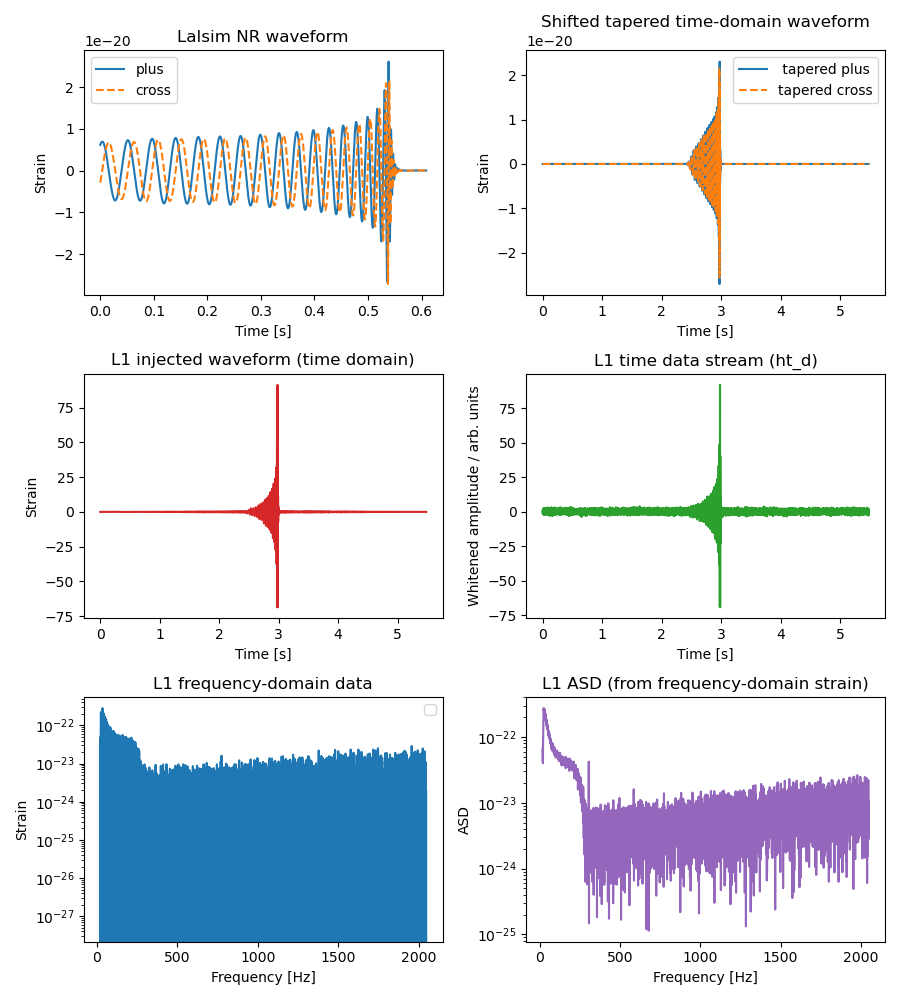

/tmp/ipykernel_107921/924384827.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))
/tmp/ipykernel_107921/924384827.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


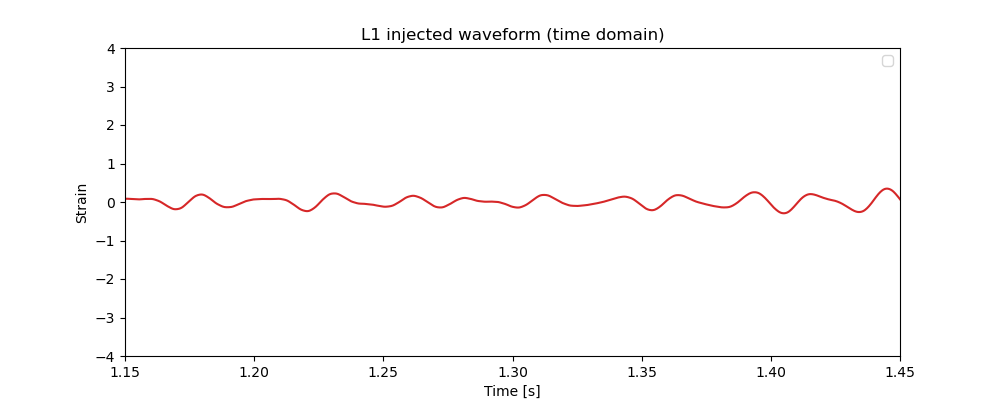

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(9, 10))
ax = axes.flatten()
ifo = ifos[1]  # Just plot for the first interferometer

# 2) Lalsim NR waveform (plus & cross)
ax[0].plot(times, original_hp, label="plus")
ax[0].plot(times, original_hc, ls="--", label="cross")
ax[0].set_title("Lalsim NR waveform")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")
ax[0].legend()

# 2) Tapered time-domain waveform (plus & cross). Output from Bilby waveform generator
ax[1].plot(time_array, time_domain["plus"], label=" tapered plus")
ax[1].plot(time_array, time_domain["cross"], ls="--", label="tapered cross")
ax[1].set_title("Shifted tapered time-domain waveform")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Strain")
ax[1].legend()

# 3) Detector injected time-series (ht_inj_det)
ax[2].plot(plot_times, ht_inj_det, color="C3")
ax[2].set_title(f"{ifo.name} injected waveform (time domain)")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Strain")

# 4) Detector time-series (ht_d)
ax[3].plot(plot_times, ht_d, color="C2")
ax[3].set_title(f"{ifo.name} time data stream (ht_d)")
ax[3].set_xlabel("Time [s]")
ax[3].set_ylabel("Whitened amplitude / arb. units")

# 5) Detector frequency-domain data
ax[4].plot(plot_frequencies, ifo.frequency_domain_strain[frequency_idxs])
ax[4].set_yscale("log")
ax[4].set_title(f"{ifo.name} frequency-domain data")
ax[4].set_xlabel("Frequency [Hz]")
ax[4].set_ylabel("Strain")
ax[4].legend()

# 6) ASD from interferometer frequency-domain strain (subset used for plotting)
ax[5].plot(plot_frequencies, hf_d, color="C4")
ax[5].set_yscale("log")
ax[5].set_title(f"{ifo.name} ASD (from frequency-domain strain)")
ax[5].set_xlabel("Frequency [Hz]")
ax[5].set_ylabel("ASD")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(plot_times, ht_inj_det, color="C3")
plt.title(f"{ifo.name} injected waveform (time domain)")
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.xlim(1.15,1.45)
plt.ylim(-4,4)
plt.legend()
plt.show()

Now we might have to save more metadata to pass to ringdown later. We should send the L1 time data stream - so injected signal with noise.

In [53]:
import pandas as pd

# 1. Initialize dictionary with the common time array (assuming all use the same time grid)
# We grab the time from the first available injection
time_array = ifos[0].time_array 
geocent_time = 1420878141.235932
#shift time_array to have the peak amplitude at geocent_time
#time_array = time_array + (geocent_time - peak_time_ifo)

#if dense_star:
#    time_array = time_array[:-1]  # Adjust for dense output if necessary
data_dict = {'time': time_array}

# 2. Loop through your window functions and collect strain
for ifo in ifos:
    # Create a unique column name like 'H1_planck' or 'L1_cos'
    col_name = f"{ifo.name}"
    data_dict[col_name] = ifo.time_domain_strain

# 3. Save to a single CSV
df = pd.DataFrame(data_dict)
df.to_csv('ringdown_tests/injection_data.csv', index=False)
print("Saved all tapers to 'ringdown_tests/injection_data.csv'")

print("\n=== METADATA FOR RINGDOWN FIT ===")
print(f"t0 (geocent_time): {geocent_time}")
print(f"ra:                {injection_parameters['ra']}")
print(f"dec:               {injection_parameters['dec']}")
print(f"psi:               {injection_parameters['psi']}")
print(f"duration:          {duration}")
print("=================================")

Saved all tapers to 'ringdown_tests/injection_data.csv'

=== METADATA FOR RINGDOWN FIT ===
t0 (geocent_time): 1420878141.235932
ra:                2.333
dec:               0.19
psi:               1.329
duration:          5.47998046875


Now create separate file with extra info I might need.

In [54]:
meta_dict = {
    "geocent_time": geocent_time,
    "ra": injection_parameters['ra'],
    "dec": injection_parameters['dec'],
    "psi": injection_parameters['psi'],
    "duration": duration,
    "f_min": minimum_frequency,
    "h1_peak_time_offset": peak_time_ifo - time_array[0]
}

df = pd.DataFrame([meta_dict])
df.to_csv('ringdown_tests/injection_metadata.csv', index=False)
print("Saved metadata to 'ringdown_tests/injection_metadata.csv'")

Saved metadata to 'ringdown_tests/injection_metadata.csv'
